## Miscelaneous tasks with Perqueue and ASE DB

### Add individual entries to the DB

First, add the entries from another DB

In [19]:
from ase.db import connect
from pathlib import Path
import shutil
from herculestools.dft import RunConfiguration as RC

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.
struct_dir = RC.structures_dir
config_home = RC.home
home = Path.cwd()
copy_db_path = struct_dir/'hexag_perovs_strained_copy.db'
old_db_path = struct_dir/'hexag_perovs_strained.db'
#old_db_path = 'structures/hexag_perovs_wdiscards.db'

db_path = shutil.copy(old_db_path, copy_db_path)
#copy_db_path =  'structures/hexag_perovs_strained_copy.db'

#files_folder = Path('NEB/Ba7Nb4MoO20_p1_e0/').resolve().as_posix()
#name = 'Ba7Nb4MoO20_p1_neb'

with connect(old_db_path) as old_db:
    rows = old_db.select(mask='uniaxial')
    for sys_row in rows:
        row_id = sys_row.id
        sys_atoms = sys_row.toatoms()
        sys_kvps = sys_row.key_value_pairs
        sys_kvps['mask'] = 'x-axis'
        sys_kvps['name'] = sys_kvps['name'].replace('uniaxial', sys_kvps['mask'])
        
        row_dir = Path(sys_row.dir).resolve()
        # Check if the directory exists in the scratch
        if Path(scratch_dir := row_dir.as_posix().replace('energy','scratch3')).is_dir():
            #print(f"The directory {scratch_dir} exists")
            old_direc = scratch_dir
        elif Path(home_dir := row_dir.as_posix().replace('scratch3','energy')).is_dir():
            # Try to fetch the directory in the home
            #print(f"The directory {home_dir} exists")
            old_direc = home_dir
        else:
            print(f"No directory found for {row_dir}")
        
        rename_dir = old_direc.replace('uniaxial', sys_kvps['mask'])
        print(f"Renaming {old_direc} to {rename_dir}")
        # Rename the old directories to the new ones
        shutil.move(old_direc, rename_dir)
        # try:
        #     shutil.move(old_direc, new_dir)
        # except FileNotFoundError:
        #     # Check if the directory was already renamed
        #     if Path(new_dir).exists():
        #         print(f"Directory {new_dir} already exists")
        #     else:
        #         print(f"Directory {old_direc} not found")
        #         continue
        try:
            new_dir = Path(rename_dir).relative_to(home).as_posix()
        except ValueError:
            new_dir = Path(rename_dir).relative_to(config_home).as_posix()

        sys_kvps['dir'] = new_dir
        
        with connect(copy_db_path) as new_db:
           new_db.update(id=row_id, name=sys_kvps['name'], mask=sys_kvps['mask'], dir=sys_kvps['dir'])    
        #break

Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/e0 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/e0
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_e0/init to /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x-axis_e0/init
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_e0/final to /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x-axis_e0/final
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/s1 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/s1
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/uniaxial/s3 to /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p1/x-axis/s3
Renaming /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_uniaxial_s1/init to /home/scratch

Then, modify the entry to match as best as possible with respect to the currrent scheme.

In [2]:

with connect(new_db_path) as db:
    sys_row = db.get(name=name)
    sys_id = sys_row.id
    sys_atoms = sys_row.toatoms()
    kvps = [kvp for kvp in sys_row]

    keys_values = {}
    keys_values['name'] = "Ba7Nb4MoO20_p1_e0_neb"
    keys_values['dir'] = files_folder
    keys_values['dopant']=int(sys_row.name[-5])
    keys_values['in_plane'] = 1.00
    db.update(sys_id, **keys_values)



Change the values of several entries at a time.

#### NEBs

In [25]:
from ase.db import connect
from pathlib import Path
import shutil

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.

db_path = 'structures/hexag_perovs_strained.db'
#copy_path = 'structures/hexag_perovs_strained_copy.db'

#copy_path = shutil.copy(db_path, copy_path)

#with connect(copy_path) as db:
with connect(db_path) as db:
    get_rows = db.select('barrier')
    kvps = {}
    for row in get_rows:
        row_id = row.id
        kvps['delta_e'] = abs(row.delta_e)
        name_parts = row.name.split('_')
        dist_name = name_parts[-2]
        print(dist_name)
        kvps['dopant'] = int(name_parts[1][-1])
        if dist_name=='s1':
            kvps['in_plane'] = 1.015
        elif dist_name=='s3':
            kvps['in_plane']=1.030
        elif dist_name=='c1':
            kvps['in_plane']=0.985
        elif dist_name=='c3':
            kvps['in_plane']=0.970
        elif dist_name=='e0':
            kvps['in_plane']=1.000
        
        db.update(row_id, **kvps)
        print(row_id,kvps)
        #break


s1
28 {'delta_e': 0.6102335000000494, 'dopant': 1, 'in_plane': 1.015}
s3
31 {'delta_e': 0.6151655599999231, 'dopant': 1, 'in_plane': 1.03}
s1
32 {'delta_e': 0.6243580099999235, 'dopant': 1, 'in_plane': 1.015}
e0
33 {'delta_e': 0.5970954699998856, 'dopant': 1, 'in_plane': 1.0}


#### Others

In [2]:
from ase.db import connect
from pathlib import Path
import shutil

# Read and generate an atoms entry from the NEB run. Write/Update it to the DB.

db_path = 'structures/hexag_perovs_strained.db'
#copy_path = 'structures/hexag_perovs_strained_copy.db'

#copy_path = shutil.copy(db_path, copy_path)

#with connect(copy_path) as db:
with connect(db_path) as db:
    get_rows = db.select(selection='in_plane=1.010')
    kvps = {}
    for row in get_rows:
        row_id = row.id
        row_in_plane = row.in_plane
        if row_in_plane==1.010:
            in_plane = 1.015
        elif row_in_plane==0.990:
            in_plane = 0.985

        print(row.id, row_in_plane)
        #db.update(row_id, in_plane=in_plane)
        #break
        

In [36]:
print([row for row in get_rows])

[]


### Change the resources of the queued jobs to the epyc96 partition.

In [1]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()
    
s = Selection(states='fw', names='preNEB_Ba7Nb4MoO20_p*')
targets = s.filter(entries)

# Modify the resources of the entries
new_res = Resources.from_string("112:1:xeon56:50h")
with PersistentQueue() as pq:
    for en in targets:
        en._task.resources = new_res
        pq.save_resources(en.key, new_res, False)
        print(en)
    
        
    # pq_key = en.key
    # #print(en)
    # with PersistentQueue() as pq:
    #     if pq.get_code(pq_key).name != 'neb.py':
    #         print(f"New resources: {new_res1} for pq key: {pq_key}")
    #         pq.save_resources(pq_key, Resources(new_res1), all=False)
    #         print(en)
        #else:
        #    print(f"New resources: {new_res2} for pq key: {pq_key}")
        #    pq.save_resources(pq_key, Resources(new_res2), all=True)
        
        #pq.resubmit(en)
    
    #break

Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/preneb.py'), args={}, resources=Resources(cores=112, processes=1, tmax=180000, nodename='xeon56')), entry_key=30, name='preNEB_Ba7Nb4MoO20_p1', mq_id=7943062, state='f', err_txt="CalculationFailed('vasp in /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_x_axis_c5/init returned an error: 1')", entry_group_key=1, pq_args={'pq_index': [1]}, data=None)


### Modify the arguments of the entry

In [2]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()
    
s = Selection(names='strain_Ba7Nb4MoO20_p3')
targets = s.filter(entries)

# Modify the resources of the entries
new_args = {'vasp': {'symprec': 1e-09, 'isym': 0, 'algo': 'VeryFast'}}
with PersistentQueue() as pq:
    for en in targets:
        pq.save_args(en.key, new_args, all=False)

with PersistentQueue() as pq:
    for en in targets:
        print(en)
        pq.resubmit(en)
        

Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/apply_strain.py'), args={'strain_list': [-5, -3, -1.5, 1.5, 3], 'mask_list': ['biaxial', 'x_axis', 'y_axis'], 'shape': [5, 3]}, resources=Resources(cores=56, processes=1, tmax=180000, nodename='xeon56')), entry_key=97, name='strain_Ba7Nb4MoO20_p3', mq_id=8125888, state='f', err_txt="CalculationFailed('vasp in /home/scratch3/armoma/phd/hex_perovs/strained/distorted/Ba7Nb4MoO20_p3/y_axis/s3 returned an error: 255')", entry_group_key=8, pq_args={'pq_index': [14]}, data=None)
8125888 ./ apply_strain.py 97 180000 +2 56:1:xeon56:50h 3:10:34 FAILED 1:43:21 [mpiexec@d088.nifl.fysik.dtu.dk] poll_for_event (../../../../../src/pm/i_hydra/libhydra/demux/hydra_demux_poll.c:159): check exit codes error
1 task removed
8125981 ./ apply_strain.py 97 180000 +2 56:1:xeon56:50h
1 task submitted
Entry(task=Task(code=PosixPath('/home/energy/armoma/phd/hex_perovs/strained/codes/apply_strain.py'), args={'strain_list': [-5, -3, -

### Modify the state of an entry

In [1]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources
from perqueue.task_classes.util_classes import EntryState
import perqueue.coordinator as coord

# Get the entries from the active pq database and modify their resources
with PersistentQueue() as pq:
    entries = pq.get_entries()
    
s = Selection(ids=55)
targets = s.filter(entries)

#new_state = EntryState('q')
with PersistentQueue() as pq:
    for en in targets:
        # Change the state of the entry
        coord.set_state(pq._backend, en.key, EntryState.succeeded, None)
        
        # Populate the data field in the entry
        #coord.set_data(pq._backend, en.key, {'db_id': 1})
        
        # Resubmit the entry
        #pq.resubmit(en)
        
        #break
        

#### Change the args of an entry.

In [4]:
from perqueue.queue import PersistentQueue
from perqueue.selection import Selection
from ase.db import connect
from perqueue.task_classes.util_classes import Resources
from perqueue.task_classes.util_classes import EntryState
import perqueue.coordinator as coord

# Get the succesful NEB jobs with PQ
with PersistentQueue() as pq:
    entries = pq.get_entries()

s = Selection(states='qr', names='strain*')
targets = s.filter(entries=entries)

resources = Resources.from_string('56:1:xeon56:50h')
#args = {'climb': True}
#data = {'trajectory': 'Ba7Nb4MoO20_p1_biaxial_e0_1.traj', 'neb_id': 43}

with PersistentQueue() as pq:
    for en in targets:
        # Store the data in the entry
        #coord.set_data(pq._backend, en.key, data)
        #pq.save_resources(en.key, resources, False)
        #key = en.key
        #pq.save_args(key, args, False)
        pq.resubmit(en)

7930385 ./ apply_strain.py 2 180000 +2 96:1:epyc96:50h 1:16 queued 0:00
1 task removed
7930418 ./ apply_strain.py 2 180000 +2 56:1:xeon56:50h
1 task submitted
7930386 ./ apply_strain.py 3 180000 +2 56:1:xeon56:50h 1:16 queued 0:00
1 task removed
7930419 ./ apply_strain.py 3 180000 +2 56:1:xeon56:50h
1 task submitted
7930387 ./ apply_strain.py 4 180000 +2 40:1:xeon40el8_768:50h 1:16 queued 0:00
1 task removed
7930420 ./ apply_strain.py 4 180000 +2 56:1:xeon56:50h
1 task submitted
7930388 ./ apply_strain.py 5 180000 +2 96:1:epyc96:50h 1:16 queued 0:00
1 task removed
7930421 ./ apply_strain.py 5 180000 +2 56:1:xeon56:50h
1 task submitted
7930389 ./ apply_strain.py 6 180000 +2 56:1:xeon56:50h 1:16 queued 0:00
1 task removed
7930422 ./ apply_strain.py 6 180000 +2 56:1:xeon56:50h
1 task submitted
7930390 ./ apply_strain.py 7 180000 +2 40:1:xeon40el8_768:50h 1:16 queued 0:00
1 task removed
7930423 ./ apply_strain.py 7 180000 +2 56:1:xeon56:50h
1 task submitted
7930391 ./ apply_strain.py 8 180

In [11]:
resources = Resources.from_string('48:1:xeon24el8_test:10m')
with PersistentQueue() as pq:
    entry= pq.get_entry(key=12)
    pq.save_resources(entry.key, resources, False)

In [ ]:
data = {'trajectory': 'Ba7Nb4MoO20_p1_biaxial_e0_1.traj', 'neb_id': 43}

## Modify the entries of the DB

In [8]:
from ase.db import connect
import shutil
from ase.io import read
from ase.dft.bandgap import bandgap
from herculestools.dft import load_run, RunConfiguration as RC

rc_home = RC.home

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select()
    for row in rows:
        if not hasattr(row, 'energy'):
            continue
        # Check for entries that have the 'x-axis' mask
        if row.mask == 'x-axis':
            #print(row.id, row.name, row.mask, row.dir)
            mask = 'x_axis'
            name = row.name.replace('x-axis', mask)
            old_dir = row.dir
            new_dir = row.dir.replace('x-axis', mask)
            #print(name, direc)
            
            db.update(row.id, mask=mask, name=name, dir=new_dir)
            # We can update the entries in the database. But we can also rename the directories the data is stored in
            #old_dir = rc_home/old_dir
            #new_dir = rc_home/new_dir
            # Move the contents of the old directory to the new one
            #shutil.move(old_dir, new_dir)
    

In [18]:
from ase.db import connect
import shutil
from ase.io import read
from ase.dft.bandgap import bandgap
from herculestools.dft import load_run, RunConfiguration as RC

rc_home = RC.home

# Connect to the database
#db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select()
    for row in rows:
        if not hasattr(row, 'energy'):
            continue
        # We now change the entries that have incorrectly assigned mask names
        mask = row.mask
        if mask not in row.name:
            #print(row.id, row.name, row.mask, row.dir)
            #Change the mask in the name
            if mask == 'x_axis':
                name = row.name.replace('x', mask)
                old_dir = row.dir
                new_dir = row.dir.replace('x', mask)
                db.update(row.id, name=name, dir=new_dir)
            if mask == 'y_axis':
                name = row.name.replace('y', mask)
                old_dir = row.dir
                new_dir = row.dir.replace('y', mask)
                db.update(row.id, name=name, dir=new_dir)
                old_dir = rc_home/old_dir
                new_dir = rc_home/new_dir
                #Move the contents of the old directory to the new one
                try:
                    shutil.move(old_dir, new_dir)
                except FileNotFoundError:
                    print(f"Directory {old_dir} not found")
                    continue
            print(name, new_dir)
        

Directory /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_s1/init not found
Directory /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_s1/final not found
Ba7Nb4MoO20_p1_x_axis_c1_vi preNEB/Ba7Nb4MoO20_p1_x_axis_c1/init
Ba7Nb4MoO20_p1_x_axis_c1_vf preNEB/Ba7Nb4MoO20_p1_x_axis_c1/final
Ba7Nb4MoO20_p1_x_axis_s1_vi preNEB/Ba7Nb4MoO20_p1_x_axis_s1/init
Ba7Nb4MoO20_p1_x_axis_s1_vf preNEB/Ba7Nb4MoO20_p1_x_axis_s1/final
Ba7Nb4MoO20_p1_x_axis_s3_vi preNEB/Ba7Nb4MoO20_p1_x_axis_s3/init
Ba7Nb4MoO20_p1_x_axis_s3_vf preNEB/Ba7Nb4MoO20_p1_x_axis_s3/final
Ba7Nb4MoO20_p1_y_axis_c1_vi /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_axis_c1/init
Ba7Nb4MoO20_p1_y_axis_c1_vf /home/scratch3/armoma/phd/hex_perovs/strained/preNEB/Ba7Nb4MoO20_p1_y_axis_c1/final


In [26]:
from ase.db import connect
import shutil
from herculestools.dft import RunConfiguration as RC

rc_home = RC.home

# Connect to the database
#db_path = 'structures/hexag_perovs_strained.db'
db_copy = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
#shutil.copy(db_path, db_copy)

# Connect to the copied database
ids = []
with connect(db_copy) as db:
    rows = db.select(selection='mask=x_axis', sort='-name')
    # Some entries have been duplicated. We need to remove the duplicates by filtering out their names.
    names_list = []
    for row in rows:
        # Get the id and name of the row
        row_id = row.id
        row_name = row.name
        # Feed the id and name to the list of duplicates
        names_list.append((row_id, row_name))
        
    # Check for duplicate names in the list
    ids_to_delete = []
    for i in range(len(names_list)-1):
        if names_list[i][1] == names_list[i+1][1]:
            # Get the id of the duplicate entry
            row_id = names_list[i+1][0]
            ids_to_delete.append(row_id)
            print(f"Deleting duplicate name: {names_list[i+1][1]}, id: {names_list[i+1][0]}")
            #break
    db.delete(ids_to_delete)

Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3_vi, id: 69
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3_vf, id: 70
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s3, id: 10
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1_vi, id: 67
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1_vf, id: 68
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_s1, id: 9
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c3, id: 22
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1_vi, id: 63
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1_vf, id: 64
Deleting duplicate name: Ba7Nb4MoO20_p1_x_axis_c1, id: 19


In [22]:
print(len(names_list))

35


## Generate a CSV file with the entries in the DB

In the following lines I will take from the current entries in the database and generate a data file I can use for consequent treatment of the data.

### Treat the DB for proper results

This does not need to be done again

In [3]:
from ase.db import connect
import shutil


"""
The NEB entries in the database need a slight adjustment to their columns 

1. The first thing that needs to change is the 'mask' column, I have to assign this value to all entries.append

2. Determine whether the entry is or not a climbing-image calculation. Assign a boolean value to the 'climb' column

3. The 'in_plane' column is a float value that needs to be assigned to all entries. 

Most of these values can be extracted from the name of the entry.

Try first with a copy DB.
"""

# Connect to the database

db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy_path)

# Generate a dictionary of in_plane values
in_plane_dict = {'s7': 1.070, 's5': 1.050, 's3': 1.030, 's1': 1.015, 'e0': 1.000, 'c1': 0.985, 'c3': 0.970, 'c5': 0.950, 'c7': 0.930}

masks_dict = {'x':'x_axis', 'y':'y_axis'}

# Connect to the copied database
with connect(db_copy_path) as db:
    # Get all the neb entries in the database
    rows = db.select(selection='barrier')
    for row in rows:
        row_id = row.id
        row_name = row.name
        # Split the name of the entry
        name_components = row_name.split('_')
        # Get the dopant
        dopant = int(name_components[1][-1])
        # Is the entry a climbing image calculation?
        if "CI" in row_name:
            climb = True
            # Get the in_plane value from the name components
            in_plane = in_plane_dict[name_components[-3]]
        else:
            climb = False
            in_plane = in_plane_dict[name_components[-2]]
        # Get the mask value from the name components, for the x and y axis the match will only be for the 'x' and 'y' characters
        mask = name_components[2]
        if mask in masks_dict.keys():
            mask = masks_dict[mask]
                

        print(row_name, mask, climb, in_plane)
        db.update(row_id, dopant=dopant, mask=mask, climb=climb, in_plane=in_plane)
        
        


Ba7Nb4MoO20_p1_x_axis_s1_neb x_axis False 1.015
Ba7Nb4MoO20_p1_x_axis_s3_neb x_axis False 1.03
Ba7Nb4MoO20_p1_biaxial_s1_neb biaxial False 1.015
Ba7Nb4MoO20_p1_biaxial_c1_neb biaxial False 0.985
Ba7Nb4MoO20_p1_biaxial_s3_neb biaxial False 1.03
Ba7Nb4MoO20_p1_x_axis_c3_neb x_axis False 0.97
Ba7Nb4MoO20_p1_x_axis_c1_neb x_axis False 0.985
Ba7Nb4MoO20_p1_biaxial_e0_neb biaxial False 1.0
Ba7Nb4MoO20_p1_biaxial_c3_neb biaxial False 0.97
Ba7Nb4MoO20_p1_x_axis_s3_CI_neb x_axis True 1.03
Ba7Nb4MoO20_p1_x_axis_c5_neb x_axis False 0.95
Ba7Nb4MoO20_p1_biaxial_c5_neb biaxial False 0.95
Ba7Nb4MoO20_p1_y_axis_s3_neb y_axis False 1.03
Ba7Nb4MoO20_p1_y_axis_s1_neb y_axis False 1.015
Ba7Nb4MoO20_p1_y_axis_c5_neb y_axis False 0.95
Ba7Nb4MoO20_p1_y_axis_c3_neb y_axis False 0.97
Ba7Nb4MoO20_p1_y_axis_c1_neb y_axis False 0.985
Ba7Nb4MoO20_p1_x_axis_c1_CI_neb x_axis True 0.985
Ba7Nb4MoO20_p1_x_axis_s1_CI_neb x_axis True 1.015
Ba7Nb4MoO20_p1_biaxial_s1_CI_neb biaxial True 1.015
Ba7Nb4MoO20_p1_biaxial_s3_CI_n

#### Modify the e0 entries so that they're not part of the starting masks

In [16]:
from ase.db import connect
import shutil
from pathlib import Path
from ase.io import read

db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy_path)

# Connect to the copied database
with connect(db_copy_path) as db:
    #rows = db.select(selection='in_plane=1.0')
    #rows = db.select(selection='jobtype=relaxation')
    rows = db.select(selection='barrier,in_plane=1.0')
    for row in rows:
        row_id = row.id
        # in_plane = 1.000
        mask = 'equil'
        # direc = Path(row.dir)
        # vasprun = direc/ 'vasprun.xml'
        # if vasprun.exists():
        # atoms = read(vasprun, index=-1)
        # energy = atoms.get_potential_energy()
        # else:
        #    break
        db.update(row_id, mask=mask)
        #print(row_id)

#### Make it easier to filter jobs by adding their jobtype

In [ ]:
from ase.db import connect
import shutil

db_path = 'structures/hexag_perovs_strained.db'
db_copy_path = 'structures/hexag_perovs_strained_copy.db'

# Copy the database to a new location
shutil.copy(db_path, db_copy_path)

jobtypes_dict = {'_neb': 'migration', '_vi':'vacancies', '_vf':'vacancies', '_r':'relaxation'}

# Connect to the copied database
with connect(db_copy_path) as db:
    rows = db.select()
    for row in rows:
        row_id = row.id
        row_name = row.name
        jobtype = 'strain'
        for key in jobtypes_dict.keys():
            if key in row_name:
                jobtype = jobtypes_dict[key]
                break
        db.update(row_id, jobtype=jobtype)
        

### Generating the CSVs

We will generate two CSV files. One will contain the information from the relaxations. And the second one, the information from the NEBs. 

#### Here, the strained calculations

In [4]:
from ase.db import connect
from pathlib import Path
import pandas as  pd
import numpy as np
import re

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'

# Read the database
with connect(db_path) as db:
    strain_rows = db.select('jobtype=strain')
    relax_rows = db.select('jobtype=relaxation')

    # Merge the two generators
    rows = [*strain_rows, *relax_rows]

    # Create a dictionary to store the data
    data_dict = {'name':[], 'natoms':[], 'dopant':[], 'mask':[], 'in_plane':[], 'energy':[]}

    for row in rows:
        data_dict['name'].append(row.name)
        data_dict['dopant'].append(row.dopant)
        data_dict['natoms'].append(row.natoms)
        data_dict['mask'].append(row.mask)
        data_dict['in_plane'].append(row.in_plane)
        data_dict['energy'].append(row.energy)
    
    # Create a pandas dataframe from the dictionary
    df = pd.DataFrame(data_dict)
    #print(df)
    df.to_csv('strained_perovskite_energies.csv', index=False)


#### Now the migration barriers

In [17]:
from ase.db import connect
from pathlib import Path
import pandas as  pd
import numpy as np
import re

# Connect to the database
db_path = 'structures/hexag_perovs_strained.db'

# Read the database
with connect(db_path) as db:
    rows = db.select('jobtype=migration')

    # Create a dictionary to store the data
    data_dict = {'name':[], 'natoms': [], 'dopant':[], 'mask':[], 'in_plane':[], 'barrier':[], 'climb':[], 'forward_e':[], 'reverse_e':[], 'delta_e':[], 'delta_e':[], 'kra':[]}
    for row in rows:
        data_dict['name'].append(row.name)
        data_dict['dopant'].append(row.dopant)
        data_dict['natoms'].append(row.natoms)
        data_dict['mask'].append(row.mask)
        data_dict['in_plane'].append(row.in_plane)
        data_dict['barrier'].append(row.barrier)
        data_dict['climb'].append(row.climb)
        data_dict['forward_e'].append(row.forward_e)
        data_dict['reverse_e'].append(row.reverse_e)
        data_dict['delta_e'].append(row.delta_e)
        data_dict['kra'].append(row.kra_energy)
    
    # Create a pandas dataframe from the dictionary
    df = pd.DataFrame(data_dict)
    #print(df)
    df.to_csv('strained_perovskite_barriers.csv', index=False)


## Generating the plots for the strained perovskites

Here we do a quick plot of the energies against strain for the distorted structures. And then, a barrier against strain for the NEB calculations.

### Plot of the strain-energy relations.

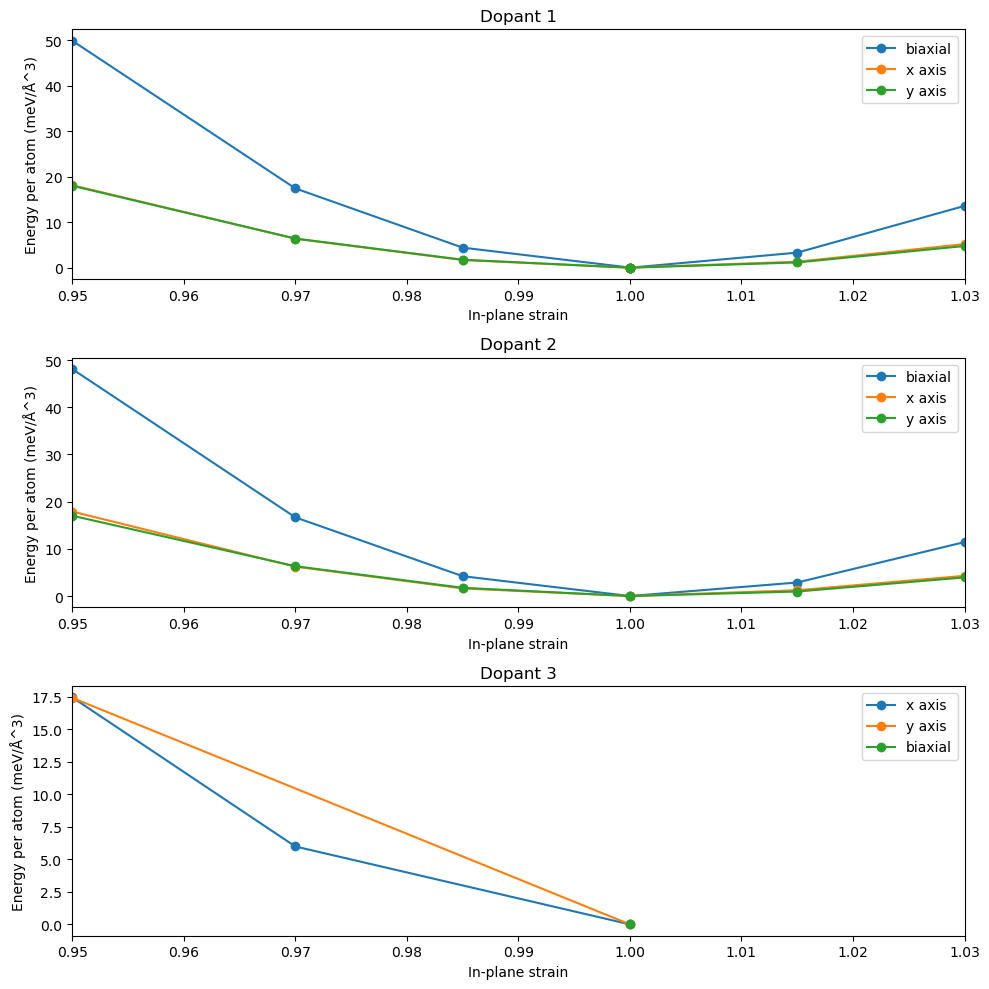

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_energies.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy

# Sort the data by the masks: biaxial, x-axis, y-axis
data = data.sort_values(by='mask')
# Get the unique dopants
dopants = data['dopant'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for dopant in dopants:
    # get the equilibrium data for the dopant
    equil_data = data[(data['dopant']==dopant) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])
# Sort the data by the in-plane strain
data = data.sort_values(by='in_plane')

# Drop the 'equil' mask data
data = data[data['mask']!='equil']

# Create a figure
fig, ax = plt.subplots(len(dopants), 1, figsize=(10, 10))

xlims = [0.95, 1.03]

names_dict = {'x_axis': 'x axis', 'y_axis': 'y axis', 'biaxial': 'biaxial'}

for dopant in dopants:
    # Get the data for the dopant
    dopant_data = data[data['dopant']==dopant]
    # Get the unique mask values
    masks = dopant_data['mask'].unique()

    # Get the equilibrium energy
    for mask in masks:
        mask_data = dopant_data[dopant_data['mask']==mask]
        min_energy = mask_data['energy'].min()
        ax[dopant-1].plot(mask_data['in_plane'], 1000*(mask_data['energy'] - min_energy)/mask_data['natoms'], label=names_dict[mask], marker='o')
    ax[dopant-1].set_xlim(xlims)
    ax[dopant-1].set_title(f'Dopant {dopant}')
    ax[dopant-1].set_xlabel('In-plane strain')
    ax[dopant-1].set_ylabel('Energy per atom (meV/Å^3)')
    ax[dopant-1].legend()
plt.tight_layout()
plt.savefig('strained_perovskite_energies.png')
plt.show()


### Now for the barriers of the NEBs

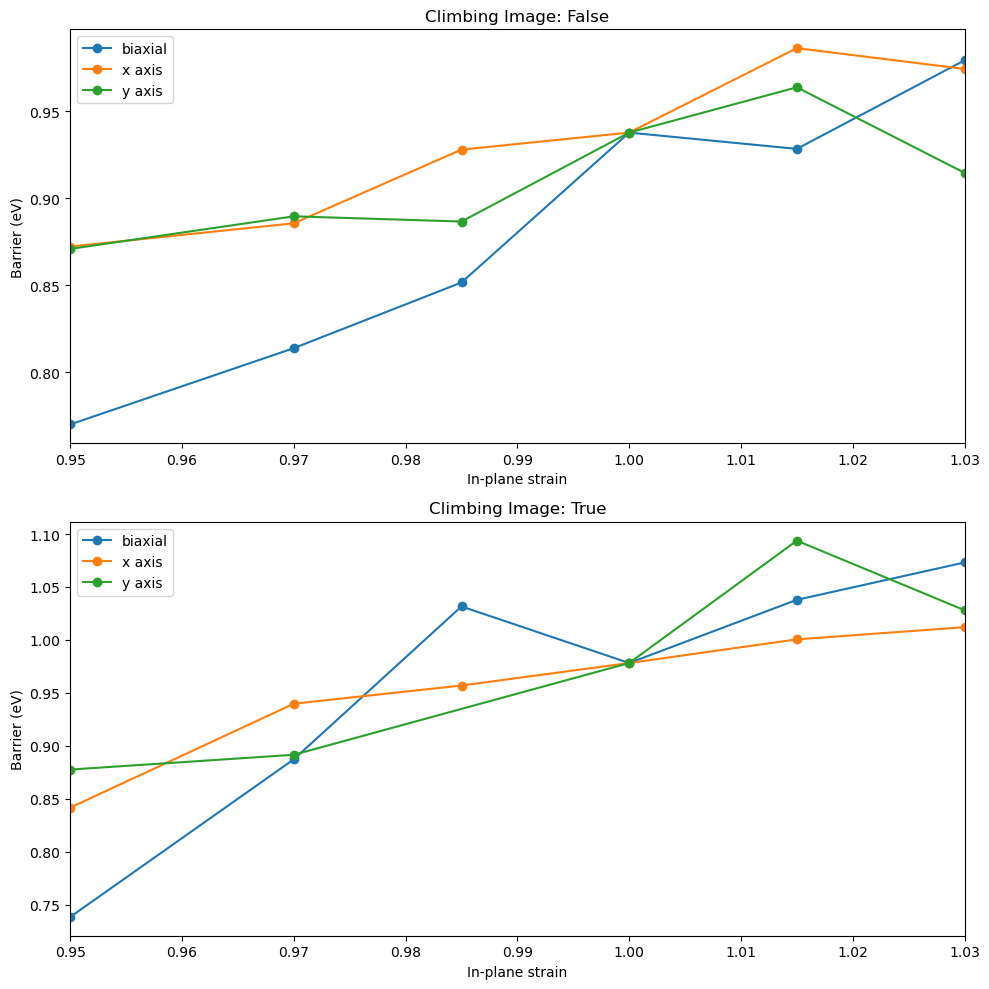

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Read the data from the csv file
data = pd.read_csv('strained_perovskite_barriers.csv')

# There will be a plot for every dopant. The markers will be different for each mask value. They will all contain the equilibrium energy
barrier_types = data['climb'].unique()

# Generate a copy of the 'equil' mask data for each of the masks in the data
for barrier_type in barrier_types:
    equil_data = data[(data['climb']==barrier_type) & (data['mask']=='equil')]
    for mask in data['mask'].unique():
        if mask != 'equil':
            mask_data = equil_data.copy()
            mask_data['mask'] = mask
            data = pd.concat([data, mask_data])

# Sort the data by the in-plane strain
data = data.sort_values(by=['in_plane','mask', 'climb'])

# Drop the 'equil' mask data
data = data[data['mask']!='equil']
data.to_csv('strained_perovskite_barrier_2.csv', index=False)

# Create a figure
fig, ax = plt.subplots(len(barrier_types), 1, figsize=(10, 10))

names_dict = {'x_axis': 'x axis', 'y_axis': 'y axis', 'biaxial': 'biaxial'}

xlims = [0.95, 1.03]

# There are two types of NEB calculations, those that are climbing image and those that are not. We will plot the barriers for each of these types
for i, barrier_type in enumerate(barrier_types):
    # Get the unique mask values
    barrier_type_data = data[data['climb']==barrier_type]
    masks = barrier_type_data['mask'].unique()
    # Get the equilibrium energy
    for mask in masks:
        mask_data = barrier_type_data[barrier_type_data['mask']==mask]
        ax[i].plot(mask_data['in_plane'], mask_data['barrier'], label=names_dict[mask], marker='o')
    ax[i].set_xlim(xlims)
    ax[i].set_title(f'Climbing Image: {barrier_type}')
    ax[i].set_xlabel('In-plane strain')
    ax[i].set_ylabel('Barrier (eV)')
    ax[i].legend()
plt.tight_layout()
plt.savefig('strained_barriers.png')
plt.show()

